In [1]:
import os
os.chdir("/content/drive/Shareddrives/yujung kim/Study/Python/time_series")

In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta, time

In [3]:
with open('data/pv.pickle', 'rb') as f:
    pv = pickle.load(f)

# scaling

In [4]:
from sklearn.preprocessing import MinMaxScaler

In [5]:
power_scaler = MinMaxScaler()
power_scaler.fit(pv[['power']])
pv['power_scale'] = power_scaler.transform(pv[['power']])

In [6]:
x_scaler = MinMaxScaler()
x_scaler.fit(pv[['dwpt', 'rhum', 'wspd', 'pres']])
pv[['dwpt', 'rhum', 'wspd', 'pres']] = x_scaler.transform(pv[['dwpt', 'rhum', 'wspd', 'pres']])

In [7]:
pv = pv.set_index('datetime')

In [8]:
tz = timezone(timedelta(hours=-6))
pv_train = pv.loc[:datetime(2006,12,30,23,tzinfo=tz)]
pv_test = pv.loc[datetime(2006,12,31,00,tzinfo=tz):]

# data loader

- torch 에서 LSTM 의 경우 
  - input: (seq_len, batch, input_size)
  - output: (seq_len, batch, num_directions * hidden_size) 

In [9]:
from torch.utils.data import DataLoader, Dataset

In [10]:
class windowDataset(Dataset):
    def __init__(self, y, input_window, output_window, num_feature, stride=1):
        #총 데이터의 개수
        L = y.shape[0]
        # seq_len
        num_samples = (L - input_window - output_window) // stride + 1

        #input과 output : shape = (window 크기, sample 개수)
        X = np.zeros([input_window, num_samples, num_feature])
        Y = np.zeros([output_window, num_samples, num_feature])

        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + input_window
            X[:,i,:] = y[start_x:end_x]

            start_y = stride*i + input_window
            end_y = start_y + output_window
            Y[:,i] = y[start_y:end_y]

        X = X.reshape(X.shape[0], X.shape[1], num_feature).transpose((1,0,2)) # (seq_len, input_window, feature)
        Y = Y.reshape(Y.shape[0], Y.shape[1], num_feature).transpose((1,0,2)) # (seq_len, output_window, feature)
        self.x = X
        self.y = Y
        self.len = len(X)

    def __getitem__(self, i):
        return self.x[i], self.y[i]

    def __len__(self):
        return self.len

In [11]:
iw = 24*7
ow = 24
num_feature = 5

train_dataset = windowDataset(pv[['power_scale', 'dwpt', 'rhum', 'wspd', 'pres']], input_window=iw, output_window=ow, num_feature=num_feature, stride=24)
train_loader = DataLoader(train_dataset, batch_size=16)

In [12]:
a = next(iter(train_loader))

In [13]:
a[0].shape

torch.Size([16, 168, 5])

In [14]:
a[1].shape

torch.Size([16, 24, 5])

In [15]:
len(train_loader)

23

# model

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm.auto import tqdm
import random
import seaborn as sns
import matplotlib.pyplot as plt

In [38]:
class lstm(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers=1): # num_layers: lstm layer 수
        super(lstm, self).__init__() 
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        # batch_first=True 인 경우 (batch, input_window, feature) 에 맞춰서 input
        self.lstm = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first=True) 
        self.linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x):
        lstm_out, hidden = self.lstm(x)
        hidden = hidden[0].squeeze() # hidden_state (1, batch, hidden_dim) -> (batch, hidden_dim)
        out = self.linear(hidden)
        return out, hidden

# train

In [63]:
def train(epochs):
    model.train()

    pbar = tqdm(range(epochs))
    for epoch in pbar:
        total_loss = 0.0

        for x, y in train_loader:
            optimizer.zero_grad()
            x = x.to(device).float()
            y = y.to(device).float()
            output, hidden = model(x)
            output = output[:,:,None] # output (batch, 24) -> (batch, 24, 1)
            loss = criterion(output, y[:,:,0].unsqueeze(2))
            loss.backward()
            optimizer.step()
            total_loss += loss.cpu().item()
        pbar.set_postfix(loss="{0:.5f}".format(total_loss/len(train_loader)))

    return output.detach().cpu().numpy(), y.detach().cpu().numpy()

In [64]:
device='cuda'
model = lstm(input_size=5, output_size=24, hidden_size=100, num_layers=1).to(device)

In [65]:
learning_rate=0.001
epoch = 1000
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.MSELoss()

In [66]:
pred, true = train(epoch)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [67]:
pred = power_scaler.inverse_transform(pred[len(pred)-1,:,0].reshape(-1,1))
real = power_scaler.inverse_transform(true[len(true)-1,:,0].reshape(-1,1))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


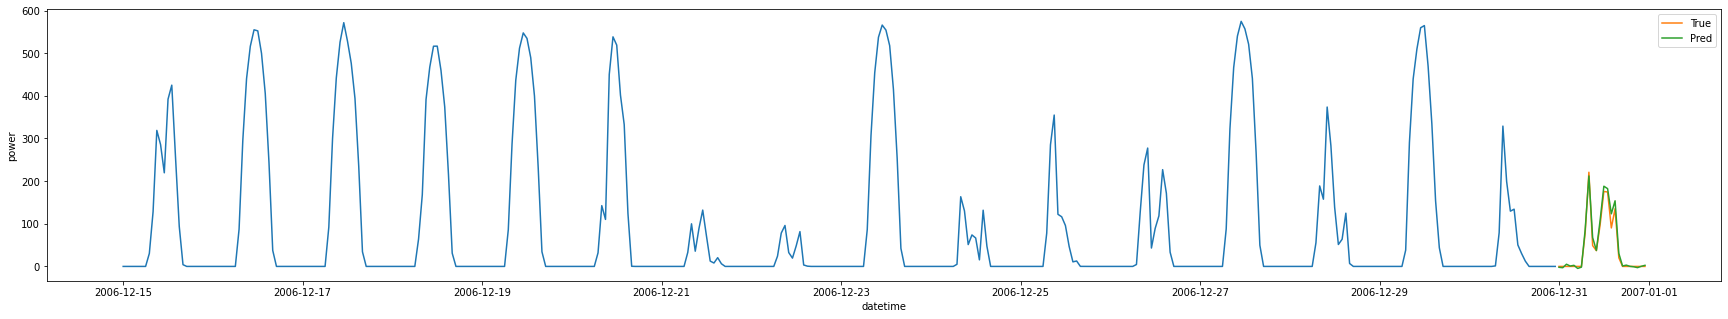

In [68]:
plt.figure(figsize=(30,5))

sns.lineplot(pv_train.loc[datetime(2006,12,15,00,tzinfo=tz):].index, pv_train.loc[datetime(2006,12,15,00,tzinfo=tz):]['power'])
sns.lineplot(pv_test.index, real.reshape(-1), label='True')
sns.lineplot(pv_test.index, pred.reshape(-1), label='Pred')
plt.legend()